In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression, Ridge
from sklearn import svm

import numpy.polynomial.polynomial as poly

In [2]:
# Reads panadas dataframe
df = pd.read_csv("cleaned_data.csv")
# Convert datetime to a number
df['SALE DATE'] = pd.to_datetime(df['SALE DATE']).astype(np.int64)
# Drop other unneeded columns
data = df.drop(columns = ["NEIGHBORHOOD", "APARTMENT NUMBER", "BUILDING CLASS CATEGORY", "TAX CLASS AT PRESENT", "BUILDING CLASS AT PRESENT", "EASE-MENT", "ADDRESS", "ZIP CODE", "BUILDING CLASS AT TIME OF SALE", "TOTAL UNITS"])
# Drop other boroughs
# data = data[(data['BOROUGH'] != 1) & (data['BOROUGH'] != 2) & (data['BOROUGH'] != 5)]
data = data[(data['BOROUGH'] == 3) | (data['BOROUGH'] == 4)]
# Convert all other strings to int values
data = data.astype(int)

In [3]:
from sklearn.utils import resample
#data = get_clean_data("cleaned_data.csv")
data['BOROUGH'].value_counts()

data_majority = data[data['BOROUGH'] == 3]
data_minority = data[data['BOROUGH'] == 4]

data_min_ds = resample(data_minority, replace = True, n_samples = 80, random_state = 123)
data_max_ds = resample(data_majority, replace = True, n_samples = 80, random_state = 123)

data_concat = pd.concat([data_max_ds, data_min_ds])
data_concat.BOROUGH.value_counts()

x1 = data_concat.drop('BOROUGH', axis = 1)
y1 = data_concat.BOROUGH
print(x1.shape, y1.shape)

(160, 10) (160,)


In [10]:
x1_scaled = preprocessing.scale(x1) #SALE DATE has already been scaled
y1 = np.array(y1)
#print(x1_scaled.shape)
#print(x1_scaled)

X1_train, X1_test, y1_train, y1_test = train_test_split(x1_scaled, y1, test_size = 0.8, train_size = 0.2)
print(X1_train.shape)
print(y1_train.shape)
svm_model = svm.SVC(probability = False, kernel = 'linear', C = 100000000) # regular logistic regression, no regularization
svm_model.fit(X1_train, y1_train)
yhat_train = svm_model.predict(X1_train)
yhat_test = svm_model.predict(X1_test)

from sklearn.metrics import accuracy_score, precision_recall_fscore_support 
precision1, recall1 ,fscore1,_ = precision_recall_fscore_support(y1_train,yhat_train,labels = [3,4], pos_label = 3,average='binary')
print("fscore (train):",fscore1)
precision2, recall2 ,fscore2,_ = precision_recall_fscore_support(y1_test,yhat_test,labels = [3,4], pos_label = 3,average='binary')
print("fscore (test):",fscore2)


(32, 10)
(32,)
fscore (train): 0.7741935483870969
fscore (test): 0.7083333333333334


/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Best fscore: 0.7580645161290323 at c value 0.1

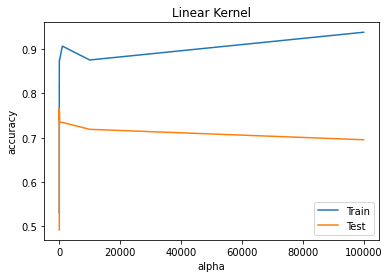

In [13]:
#Linear Kernel 
alpha_values = [10**i for i in range(-5,6)]
acc_linear_train = [] 
acc_linear_test = []
fscore_linear = -100
c_linear = -1
f_scores = []

for alpha in alpha_values: 
    linear = svm.SVC(probability = False, kernel = 'linear', C = alpha)
    linear.fit(X1_train, y1_train)
    yhat_train = linear.predict(X1_train)
    yhat_test = linear.predict(X1_test)
    acc_linear_train.append(np.mean(yhat_train == y1_train))
    acc_linear_test.append(np.mean(yhat_test == y1_test))
    precision, recall ,fscore,_ = precision_recall_fscore_support(y1_test,yhat_test,labels = [3,4], pos_label = 3,average='binary')
    f_scores.append(fscore)
    if fscore > fscore_linear: 
        c_linear = alpha 
        fscore_linear = fscore
        
print("Best fscore:",fscore_linear,"at c value",c_linear)

plt.plot(alpha_values, acc_linear_train, alpha_values, acc_linear_test)
plt.legend(['Train','Test'])
plt.xlabel('alpha')
plt.ylabel('accuracy')
plt.title('Linear Kernel')

print(alpha_values, acc_linear_train, acc_linear_test)
print(f_scores)

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Best fscore: 0.762589928057554 at c value 1000

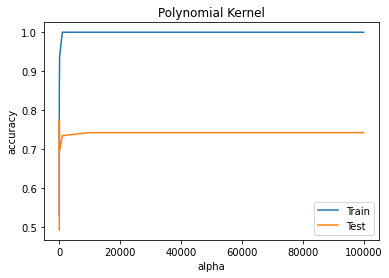

In [14]:
#Poly Kernel
acc_poly_train = [] 
acc_poly_test = []
fscore_poly = -100 
c_linear = -1
f_scores = []
for alpha in alpha_values: 
    poly = svm.SVC(probability = False, kernel = 'poly', C = alpha)
    poly.fit(X1_train, y1_train)
    yhat_train = poly.predict(X1_train)
    yhat_test = poly.predict(X1_test)
    acc_poly_train.append(np.mean(yhat_train == y1_train))
    acc_poly_test.append(np.mean(yhat_test == y1_test))

    precision, recall ,fscore,_ = precision_recall_fscore_support(y1_test,yhat_test,labels = [3,4], pos_label = 3,average='binary')
    f_scores.append(fscore)
    if fscore > fscore_poly: 
        c_poly = alpha 
        fscore_poly = fscore

print("Best fscore:",fscore_poly,"at c value",c_poly)

plt.plot(alpha_values, acc_poly_train, alpha_values, acc_poly_test)
plt.legend(['Train','Test'])
plt.xlabel('alpha')
plt.ylabel('accuracy')
plt.title('Polynomial Kernel')

print(alpha_values, acc_poly_train, acc_poly_test)
print(f_scores)

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared-libs/python3.7/py/lib/python3.7/site-p

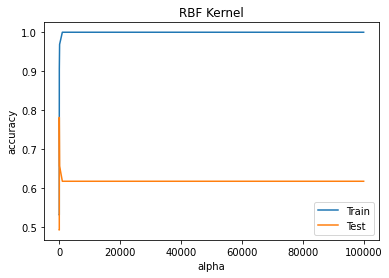

In [15]:
#RBF Kernel
acc_rbf_train = [] 
acc_rbf_test = []
c_rbf = -1
fscore_rbf = -100
f_scores = []

for alpha in alpha_values: 
    rbf = svm.SVC(probability = False, kernel = 'rbf', C = alpha)
    rbf.fit(X1_train, y1_train)
    yhat_train = rbf.predict(X1_train)
    yhat_test = rbf.predict(X1_test)
    acc_rbf_train.append(np.mean(yhat_train == y1_train))
    acc_rbf_test.append(np.mean(yhat_test == y1_test))
    
    precision, recall ,fscore,_ = precision_recall_fscore_support(y1_test,yhat_test,labels = [3,4], pos_label = 3,average='binary')
    f_scores.append(fscore)
    if fscore > fscore_rbf: 
        c_rbf = alpha 
        fscore_rbf = fscore

print("Best fscore:",fscore_rbf,"at c value",c_rbf)
        
plt.plot(alpha_values, acc_rbf_train, alpha_values, acc_rbf_test)
plt.legend(['Train','Test'])
plt.xlabel('alpha')
plt.ylabel('accuracy')
plt.title('RBF Kernel')

print(alpha_values, acc_rbf_train, acc_rbf_test)
print(f_scores)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=47c5d483-7427-4b12-afc5-c21a2f7e3d4f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>